In [24]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Any, Union
from openpyxl import load_workbook
from tqdm.autonotebook import tqdm

In [25]:
PATH_THEORY = "../../Data/Theory/MasterNuclei.xlsx"


In [26]:
# Matplotlib settings all LATEX
import matplotlib
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"], "size":18})
rc("text", usetex=True)

In [27]:
MPLHEP = False
if MPLHEP:
    import mplhep as hep
    plt.style.use(hep.style.CMS)

In [28]:
sys.path.append("../../nuclearpy_models")
from models.BE import dz_be, semf_be
from models.BE import dz_be, semf_be, sr_be
from utils.metrics import RegressionMetrics

In [29]:
exp_df = pd.read_csv('../../Data/Experimental/AME2020.csv', delimiter=',').query("Z>15").drop_duplicates(subset=['Z', 'N']).query("Z<50")
exp_df["A"] = exp_df["Z"] + exp_df["N"]
exp_df = exp_df.query("Z <= 50")

In [30]:
exp_df["semf_pred"] = exp_df.apply(lambda x: semf_be(x["Z"], x["N"]), axis=1)
exp_df["dz_pred"] = exp_df.apply(lambda x: dz_be(x["Z"], x["N"]), axis=1)
exp_df["sr_pred"] = (exp_df.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1))
exp_df["sr_error"] = exp_df["sr_pred"] - exp_df["BE"]
exp_df["dz_error"] = exp_df["dz_pred"] - exp_df["BE"]


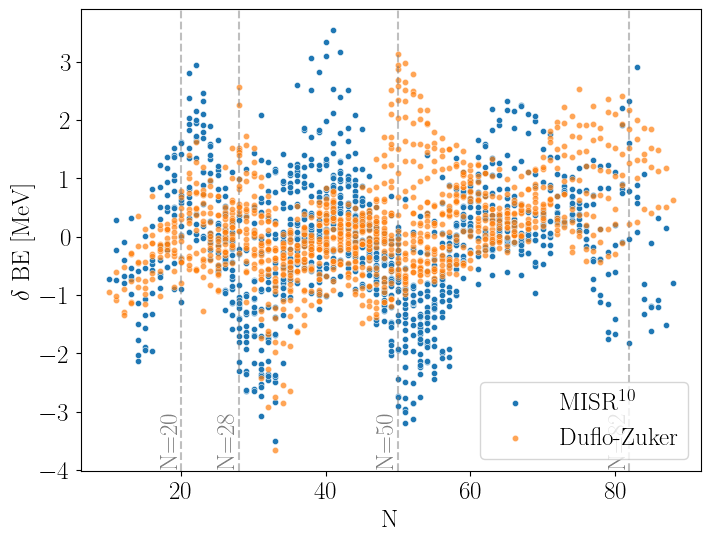

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(data=exp_df, x="N", y="sr_error", label=r"MISR$^{10}$", s=20)
sns.scatterplot(data=exp_df, x="N", y="dz_error", label="Duflo-Zuker", alpha=0.7, s=20)

# Labels for scientific notation
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.set(xlabel="N", ylabel=r"$\delta$ BE [MeV]")
# hlines on the magic numbers
magic_numbers = [20, 28, 50, 82]
for i in magic_numbers:
    ax.axvline(i, color="grey", linestyle="--", alpha=0.5)
    # Add vertical text to each line
    ax.text(i, -3.5, f"N={i}", rotation=90, verticalalignment="center", horizontalalignment="right", color="grey")
plt.savefig("./plots/sr_dz_error.pdf", bbox_inches="tight")

#### Loading test

In [32]:
PATH_THEORY = "../../Data/Theory/MasterNuclei.xlsx"
def get_sheets_name(filename):
    workbook = load_workbook(filename)
    return workbook.sheetnames


used_dfs = [
    "DD-ME2",
    # "SKMS",
    "HFB24",
    "NL3S",
    "UNEDF1",
]

th_datastes = get_sheets_name(PATH_THEORY)
th_datastes = [th_dataste for th_dataste in used_dfs if th_dataste != "AME2020"]

In [33]:
th_datastes

['DD-ME2', 'HFB24', 'NL3S', 'UNEDF1']

In [34]:
thdfs = {th_dataste: pd.read_excel(PATH_THEORY, sheet_name=th_dataste).query("Z >= 12 and N>=12").query("(N+Z)<250") for th_dataste in th_datastes}

In [35]:
def get_th_pred(Z, N, df_th):
    try:
        return df_th[(df_th["Z"] == Z) & (df_th["N"] == N)]["BE"].values[0]
    except:
        return np.nan

def patient_semf(Z, N):
    try:
        return dz_be(Z, N)
    except Exception as e:
        return np.nan

all_th_dfs = {}
all_th_in_exp = {}
for df_name in used_dfs:
    foo = thdfs.get(df_name).copy()
    foo["th_pred"] = foo.apply(lambda x: get_th_pred(x["Z"], x["N"], thdfs[df_name]), axis=1)
    foo["dz_pred"] = foo.apply(lambda x: patient_semf(x["Z"], x["N"]), axis=1)
    foo["dz_diff"] = foo.apply(lambda x: x["dz_pred"] - x["th_pred"], axis=1)
    foo["sr"] = foo.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1)
    all_th_dfs[df_name] = foo.dropna()
    foo = exp_df.copy()
    foo["th_pred"] = foo.apply(lambda x: get_th_pred(x["Z"], x["N"], thdfs[df_name]), axis=1)
    foo["dz_pred"] = foo.apply(lambda x: patient_semf(x["Z"], x["N"]), axis=1)
    foo["dz_diff"] = foo.apply(lambda x: x["dz_pred"] - x["th_pred"], axis=1)
    foo["sr"] = foo.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1)
    all_th_in_exp[df_name] = foo.dropna()


# Regression Metrics

In [36]:
exp_df = exp_df.query("Z >= 12").query("Z<=50")

In [37]:
semf_metrics = RegressionMetrics(exp_df["BE"], exp_df["semf_pred"], "SEMF")()
dz_metrics = RegressionMetrics(exp_df["BE"], exp_df["dz_pred"], "DZ")()
dz_sr_metrics = RegressionMetrics(exp_df["BE"], exp_df["sr_pred"], "sr")()
results = pd.concat([semf_metrics, dz_metrics, dz_sr_metrics], axis=0)

for df_name in used_dfs:
   res = (RegressionMetrics(all_th_in_exp[df_name]["BE"], all_th_in_exp[df_name]["th_pred"], df_name)())
   results = pd.concat([results, res], axis=0)
all_th_dfs: Dict[str, pd.DataFrame]

results[["RMSE"]].sort_values(by="RMSE", inplace=False).rename(columns={"RMSE": "RMSE [MeV]"})

sr_rmse = results.reset_index().query("index == 'sr'")["RMSE"].values[0]
dz_rmse = results.reset_index().query("index == 'DZ'")["RMSE"].values[0]

In [38]:
results[["MAE", "RMSE"]]

,MAE,RMSE
SEMF,3.362097,4.701649
DZ,0.612632,0.837769
sr,0.862915,1.111217
DD-ME2,2.576952,2.893044
HFB24,0.548867,0.735537
NL3S,2.007207,2.486782
UNEDF1,1.770505,2.076440


In [39]:
def plot_isotope_be(
    df: pd.DataFrame,
    models: List[callable] = [dz_be, dz_be],
    model_names: List[str] = ["DZ", "SR"],
    fixed_z: int = 50,
    n_max = 120,
    ):

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    foo_df = df.query(f"Z=={fixed_z}")
    n_min = foo_df["N"].min()
    ns_in = foo_df["N"].values
    ns_out = np.arange(ns_in.max(), n_max)
    all_ns = np.concatenate([ns_in, ns_out])
    y = np.array([dz_be(fixed_z, n) for n in all_ns])
    ax.plot(foo_df["N"], foo_df["BE"]*0, label="Duflo Zuker", color="black", alpha=0.5)
    plt.errorbar(foo_df["N"], foo_df["BE"], yerr=foo_df["uBE"], fmt="o", label="Experiment", color="black")
    ax.hlines(0, n_min, n_max, color="black", linestyle="-")
    SEMF_error = foo_df["dz_pred"] - foo_df["BE"]
    sns.scatterplot(x="N", y=SEMF_error, data=foo_df, ax=ax, label=None, color="black")
    for i, (model, name) in enumerate(zip(models, model_names)):
        preds_in = np.array([model(fixed_z, n) for n in all_ns])
        errors = y - preds_in
        sns.scatterplot(x=all_ns, y=errors, ax=ax, color=f"C{i}", s=5)
        sns.lineplot(x=all_ns, y=errors, ax=ax, color=f"C{i}", linestyle=":", label=name)
    for j, df_name in enumerate(used_dfs):
        sns.scatterplot(x="N", y="dz_diff", data=all_th_dfs[df_name].query(f"Z=={fixed_z}"), ax=ax, s=10, color=f"C{j+2+i}")
        sns.lineplot(x="N", y="dz_diff", data=all_th_dfs[df_name].query(f"Z=={fixed_z}"), ax=ax, linestyle="--", label=df_name,  color=f"C{j+2+i}")

    ax.set(xlabel="N", ylabel=r"$\delta(BE)$ [MeV]", xlim=(n_min, n_max), ylim=(-10, 10))
    # put the legend in the left down corner
    ax.legend(fontsize=14)
    # Add annotations inside good looking boxes
    ax.annotate(f"Z={fixed_z}", xy=(0.5, 0.9), xycoords="axes fraction", fontsize=22)
    ax.legend(fontsize=14)
    plt.savefig(f"BE_{fixed_z}.pdf", bbox_inches="tight")

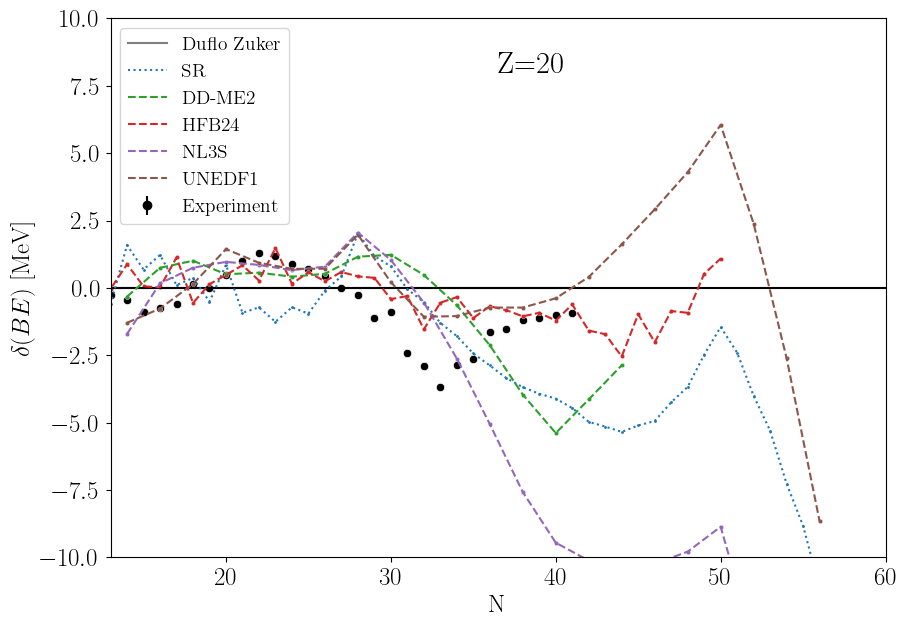

In [40]:
plot_isotope_be(exp_df, models=[sr_be],
                model_names = ["SR"],
                fixed_z=20, n_max=60)

# Unseen data

In [41]:
# full_exp_df = pd.read_excel("../../Data/Theory/MasterNuclei.xlsx", sheet_name="AME2020").query("Z>=12").query("Z<=50")
be_test = pd.read_csv("/Users/jose/Documents/Works/MIT/AI/PyMassModels/Data/Experimental/be_test.csv", delimiter=",").query("Z>=12").query("Z<=50")
be_test["is_test"] = [True] * len(be_test)
be_train = pd.read_csv("/Users/jose/Documents/Works/MIT/AI/PyMassModels/Data/Experimental/be_train.csv", delimiter=",").query("Z>=12").query("Z<=50")
be_train["is_test"] = [False] * len(be_train)
full_exp_df = pd.concat([be_test, be_train], axis=0)

In [42]:
%%capture
full_exp_df["sr_pred"] = full_exp_df.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1)
full_exp_df["SEMF"] = full_exp_df.apply(lambda x: semf_be(x["Z"], x["N"]), axis=1)
full_exp_df["dz_pred"] = full_exp_df.apply(lambda x: dz_be(x["Z"], x["N"]), axis=1)

In [43]:
full_exp_df = full_exp_df.query("Z > 12 and Z <= 50")

# Smart ensemble of the models

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ARDRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Create the linear regression model
model_pred_be = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=True, interaction_only=False),
    StandardScaler(),
    ARDRegression(),
)
# Train the model
model_pred_be.fit(full_exp_df.query("is_test == False")[["sr_pred", "dz_pred", "N", "Z"]].values,
          full_exp_df.query("is_test == False")["BE"])

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('ardregression', ARDRegression())])

In [45]:
def resample_data_from_uncertainties(df: pd.DataFrame) -> pd.DataFrame:
    """
    Resample the data from the uncertainties
    """
    new_target_df = df.copy().sample(frac=0.8, replace=True)
    new_target_df["BE"] = np.random.normal(new_target_df["BE"], new_target_df["uBE"])
    return new_target_df

def train_models_on_resampled_data(df: pd.DataFrame, n_samples: int = 20) -> List[ARDRegression]:
    """
    Train the models on the resampled data
    """
    ndf = df.copy()
    models = []
    for i in range(n_samples):
        sampled_df = resample_data_from_uncertainties(ndf)
        model = make_pipeline(
            PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
            StandardScaler(),
            ARDRegression(),
        )
        model.fit(sampled_df[["sr_pred", "dz_pred", "N", "Z"]].values, sampled_df["BE"].values)
        models.append(model)
    return models

def get_comitee_predictions(models: List[ARDRegression], X: np.ndarray) -> np.ndarray:
    """
    Get the predictions from the comitee
    """
    preds = np.array([model.predict(X, return_std=True) for model in models])
    m_pred = preds[:, 0, :]
    m_std = preds[:, 1, :]
    return m_pred.mean(axis=0)[0], m_std.mean(axis=0)[0]


In [46]:
models = train_models_on_resampled_data(full_exp_df)
def model_ensemble(Z, N, model=model_pred_be):
    inpupt_sr = sr_be(Z, N)
    input_dz = dz_be(Z, N)
    # X = np.array([[inpupt_sr, input_dz, N, Z]])
    # return get_comitee_predictions(models, X)
    pred, unc = model.predict(np.array([[inpupt_sr, input_dz, N, Z]]), return_std=True)
    return pred[0], unc[0]


In [47]:
model_ensemble(20, 20)

(342.36745297515023, 0.62665029594763)

In [48]:
ensemble_pred = full_exp_df.apply(lambda x: model_ensemble(x["Z"], x["N"])[0], axis=1)
ensemble_unc = full_exp_df.apply(lambda x: model_ensemble(x["Z"], x["N"])[1], axis=1)
full_exp_df["ensemble_pred"] = ensemble_pred
full_exp_df["ensemble_error"] = full_exp_df["ensemble_pred"] - full_exp_df["BE"]

RMSE: 0.632, MAE: 0.473


<Axes: xlabel='N', ylabel='ensemble_error'>

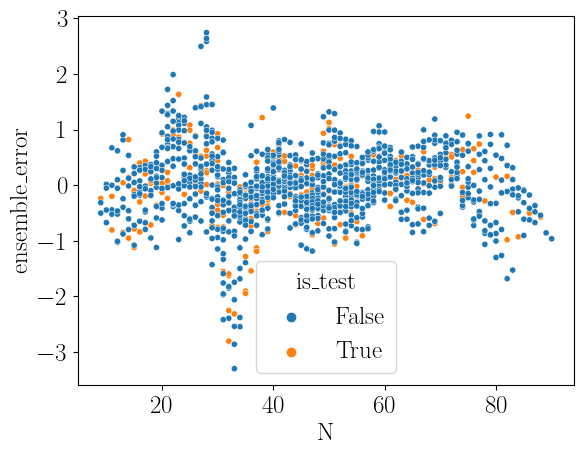

In [49]:
rmse, mae = np.sqrt(np.mean(full_exp_df.query("is_test==1")["ensemble_error"]**2)), np.mean(np.abs(full_exp_df.query("is_test==1")["ensemble_error"]))
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}")
sns.scatterplot(x="N", y="ensemble_error", data=full_exp_df, s=20, hue="is_test")

In [50]:
trmse, tmae = np.sqrt(np.mean(full_exp_df.query("is_test==0")["ensemble_error"]**2)), np.mean(np.abs(full_exp_df.query("is_test==0")["ensemble_error"]))
print(f"RMSE: {trmse:.3f}, MAE: {tmae:.3f}")

RMSE: 0.622, MAE: 0.457


In [51]:
base_mae = 0.548867
relative_improvement = (base_mae - mae) / base_mae
relative_improvement

0.13797291198526174

# Neutron Separation energies

In [52]:
sep_df = full_exp_df.copy().query("Z>=12")

In [53]:
def predict_sn(Z, N, model):
    model_up = model(Z, N+1)
    model_down = model(Z, N)
    if isinstance(model_up, tuple):
        return model_up[0] - model_down[0], (model_up[1] + model_down[1])/2
    else:
        return model_up - model_down

def experimental_sn(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "sn_exp"] = df[(df["Z"] == row["Z"]) & (df["N"] == row["N"]+1)]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "sn_exp"] = np.nan
    return df

def theory_sn(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z) & (th_df["N"] == N+1)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan


In [54]:
def ensembled_sn(Z, N, models=models):
    # take two models of models and compute the sn
    all_sn = []
    all_sn_unc = []
    for model in (models):
        sn, unc = predict_sn(Z, N, lambda Z, N: model_ensemble(Z, N, model))
        all_sn.append(sn)
        all_sn_unc.append(unc)
    mean_sn = np.mean(all_sn)

    # We now have to propagate the uncertainties
    std_sn = np.std(all_sn)
    mean_unc = np.mean(all_sn_unc)
    total_unc = np.sqrt(mean_unc**2 + std_sn**2)
    return mean_sn, total_unc

In [55]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [56]:
sep_df["exp_sn"] = experimental_sn(sep_df)["sn_exp"]
sep_df["sr_sn"] = sep_df.apply(lambda x: predict_sn(x["Z"], x["N"], sr_be), axis=1)
sep_df["dz_sn"] = sep_df.apply(lambda x: predict_sn(x["Z"], x["N"], dz_be), axis=1)
ens_sn = sep_df.progress_apply(lambda x: ensembled_sn(x["Z"], x["N"]), axis=1)
sep_df["ensemble_sn"] = [x[0] for x in ens_sn]
sep_df["unc_sn"] = [x[1] for x in ens_sn]

  0%|          | 0/1266 [00:00<?, ?it/s]

In [57]:
for th_name in used_dfs:
    sep_df[f"{th_name}_sn"] = sep_df.apply(lambda x: theory_sn(x["Z"], x["N"], thdfs[th_name]), axis=1)

In [58]:
def get_experimiental_unc_sn(Z, N, df):
    try:
        return df[(df["Z"] == Z) & (df["N"] == N+1)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan

In [59]:
dz_rmse = np.sqrt(np.mean((sep_df["exp_sn"] - sep_df["dz_sn"])**2))
sr_rmse = np.sqrt(np.mean((sep_df["exp_sn"] - sep_df["sr_sn"])**2))
ensm_rmse = np.sqrt(np.mean((sep_df["exp_sn"] - sep_df["ensemble_sn"])**2))
undef_1_rmse = np.sqrt(np.mean((sep_df["exp_sn"] - sep_df["UNEDF1_sn"])**2))
print(f"SR RMSE: {sr_rmse}, DZ RMSE: {dz_rmse}, Ensemble RMSE: {ensm_rmse}, UNEDF1 RMSE: {undef_1_rmse}")

SR RMSE: 1.7941326599188143, DZ RMSE: 1.699810518705291, Ensemble RMSE: 1.6967131068443597, UNEDF1 RMSE: 1.5243561344267342


In [276]:
def plot_sn_energy(fixed_z, n_min, n_max, annotation_text="", save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    foo_df = sep_df.query(f"Z=={fixed_z}")# and N>={n_min} and N<={n_max}")
    # predict for models

    pres = [predict_sn(fixed_z, n, model_ensemble)[0] for n in range(n_min, n_max+1)]
    unc_pred = [predict_sn(fixed_z, n, model_ensemble)[1] for n in range(n_min, n_max+1)]
    predz = [predict_sn(fixed_z, n, dz_be) for n in range(n_min, n_max+1)]
    # experimental
    exp = []
    unc = []
    ns = []
    for n in range(n_min, n_max+1):
        try:
            exp.append(sep_df[(sep_df["Z"] == fixed_z) & (sep_df["N"] == n)]["exp_sn"].values[0])
            unc.append(get_experimiental_unc_sn(fixed_z, n, sep_df))
            ns.append(n)
        except:
            exp.append(np.nan)
            unc.append(np.nan)
    plt.errorbar(range(n_min, n_max+1), exp, yerr=unc, label=None, color="black")
    # scatter as boxes
    sns.scatterplot(x=range(n_min, n_max+1), y=exp, label="Experiment", color="black", marker="s")
    # Color the area between the uncertainty
    ax.fill_between(range(n_min, n_max+1), np.array(exp)-np.array(unc), np.array(exp)+np.array(unc), color="black", alpha=0.1)
    # For uncertainty
    print(len(unc), len(foo_df["exp_sn"]))

    sns.lineplot(x="N", y="exp_sn", data=foo_df, color="black")
    # For sr... put the errorbars in the area wehre there are experimental data
    # no line for the pres
    plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="f(MISR)", color="blue", capsize=5, alpha=0.5)
    # after the experimental data ends (max(ns)), fill the area with the uncertainty

    # sns.scatterplot(x=range(n_min, n_max+1), y=pres, label="Ensemble", color="red", s=200, marker="+")
    # For dz
    sns.scatterplot(x=range(n_min, n_max+1), y=predz, label="Duflo Zucker", color="red", marker="*", s=200)
    # sns.scatterplot(x="N", y="dz_sn", data=foo_df, label="DZ", color="blue")
    sns.scatterplot(x="N", y="UNEDF1_sn", data=foo_df, label="UNEDF1", color="green", marker="x", s=80)
    # Plot an horizontal line at 0
    ax.hlines(0, n_min, n_max, color="black", linestyle="--", alpha=0.5)
    # sns.scatterplot(x="N", y="ensemble_sn", data=foo_df, label="Ensemble", color="orange")
    ax.set(xlabel="N", ylabel=r"$S_n$ [MeV]")
    ax.set_xlim(n_min, n_max+1)
    ax.set_ylim(-5, 8)
    ax.legend(fontsize=22, loc="lower left")
    # Add an annotation for the $Z$ value and text
    if annotation_text:
        ax.annotate(annotation_text, xy=(0.5, 0.9), xycoords="axes fraction", fontsize=22)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")


16 35


/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_11747/150462382.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="f(MISR)", color="blue", capsize=5, alpha=0.5)


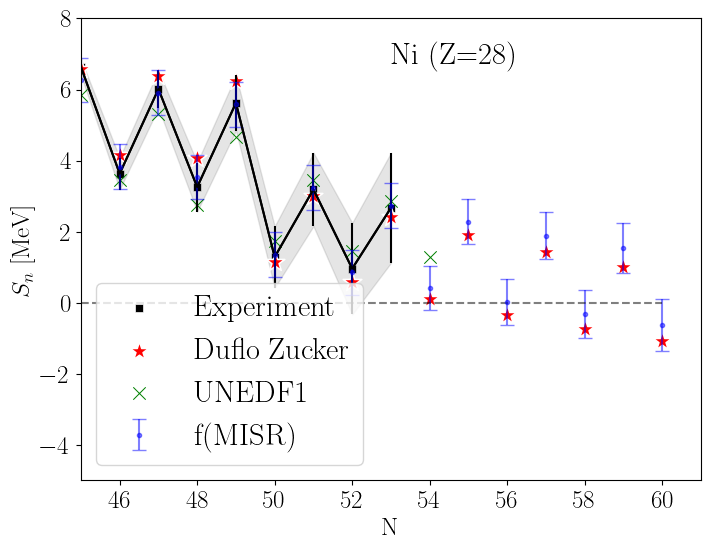

In [277]:
plot_sn_energy(28, 45, 60, "Ni (Z=28)", "sn_ni.pdf")

24 29


/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_11747/93849970.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="Ensemble", color="blue", capsize=5, alpha=0.5)


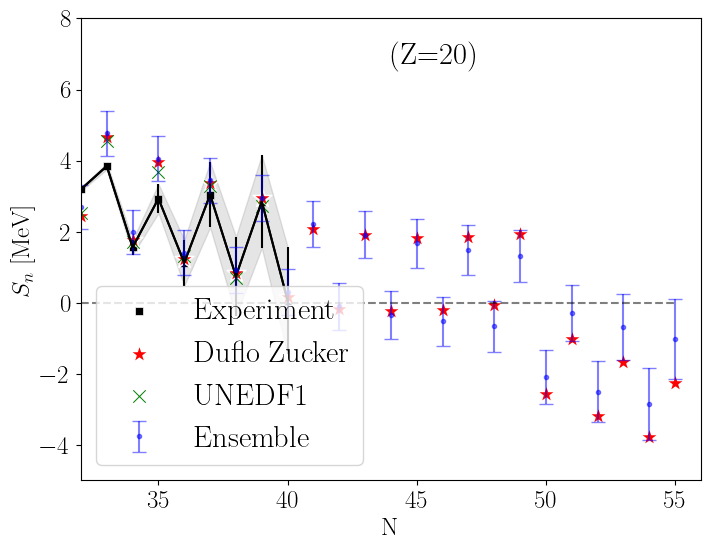

In [275]:
plot_sn_energy(20, 35, 55, "(Z=20)")

# Proton Separation energies
Now we will repeat the same process for the proton separation energies.

In [63]:
# do the same we had for the neutron separation energy but now for protons
def predict_sp(Z, N, model):
    model_up = model(Z+1, N)
    model_down = model(Z, N)
    if isinstance(model_up, tuple):
        return model_up[0] - model_down[0], (model_up[1] + model_down[1])/2
    else:
        return model_up - model_down

def experimental_sp(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "sp_exp"] = df[(df["Z"] == row["Z"]+1) & (df["N"] == row["N"])]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "sp_exp"] = np.nan
    return df

def theory_sp(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z+1) & (th_df["N"] == N)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan


In [64]:
def get_experimiental_unc_sp(Z, N, df):
    try:
        return df[(df["Z"] == Z+1) & (df["N"] == N)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan

In [65]:
for th_name in used_dfs:
    sep_df[f"{th_name}_sp"] = sep_df.apply(lambda x: theory_sp(x["Z"], x["N"], thdfs[th_name]), axis=1)

In [66]:
def ensemble_sp(Z, N, models=models):
    # take two models of models and compute the sn
    all_sp = []
    all_sp_unc = []
    for model in (models):
        sp, unc = predict_sp(Z, N, lambda Z, N: model_ensemble(Z, N, model))
        all_sp.append(sp)
        all_sp_unc.append(unc)
    mean_sp = np.mean(all_sp)

    # We now have to propagate the uncertainties
    std_sp = np.std(all_sp)
    mean_unc = np.mean(all_sp_unc)
    total_unc = np.sqrt(mean_unc**2 + std_sp**2)
    return mean_sp, total_unc

In [67]:
sep_df["exp_sp"] = experimental_sp(sep_df)["sp_exp"]
sep_df["sr_sp"] = sep_df.apply(lambda x: predict_sp(x["Z"], x["N"], sr_be), axis=1)
sep_df["dz_sp"] = sep_df.apply(lambda x: predict_sp(x["Z"], x["N"], dz_be), axis=1)
ens_sp = sep_df.progress_apply(lambda x: ensemble_sp(x["Z"], x["N"]), axis=1)
sep_df["ensemble_sp"] = [x[0] for x in ens_sp]
sep_df["unc_sp"] = [x[1] for x in ens_sp]


  0%|          | 0/1266 [00:00<?, ?it/s]

In [267]:
def plot_sp_energy(fixed_z, n_min, n_max, annotation_text="", save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    foo_df = sep_df.query(f"Z=={fixed_z}")# and N>={n_min} and N<={n_max}")
    # predict for models
    pres = [predict_sp(fixed_z, n, model_ensemble)[0] for n in range(n_min, n_max+1)]
    unc_pred = [predict_sp(fixed_z, n, model_ensemble)[1] for n in range(n_min, n_max+1)]
    predz = [predict_sp(fixed_z, n, dz_be) for n in range(n_min, n_max+1)]
    # experimental
    exp = []
    unc = []
    ns = []
    for n in range(n_min, n_max+1):
        try:
            exp.append(sep_df[(sep_df["Z"] == fixed_z) & (sep_df["N"] == n)]["exp_sp"].values[0])
            unc.append(get_experimiental_unc_sn(fixed_z, n, sep_df))
            ns.append(n)
        except:
            exp.append(np.nan)
            unc.append(np.nan)
    plt.errorbar(range(n_min, n_max+1), exp, yerr=unc, label=None, color="black")
    # scatter as boxes
    sns.scatterplot(x=range(n_min, n_max+1), y=exp, label="Experiment", color="black", marker="s")
    # Color the area between the uncertainty
    ax.fill_between(range(n_min, n_max+1), np.array(exp)-np.array(unc), np.array(exp)+np.array(unc), color="black", alpha=0.1)
    # For uncertainty
    print(len(unc), len(foo_df["exp_sp"]))

    sns.lineplot(x="N", y="exp_sp", data=foo_df, color="black")
    # For sr... put the errorbars in the area wehre there are experimental data
    # no line for the pres
    plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="f(MISR)", color="blue", capsize=5, alpha=0.5)
    # after the experimental data ends (max(ns)), fill the area with the uncertainty

    # sns.scatterplot(x=range(n_min, n_max+1), y=pres, label="Ensemble", color="red", s=200, marker="+")
    # For dz
    sns.scatterplot(x=range(n_min, n_max+1), y=predz, label="Duflo Zucker", color="red", marker="*", s=200)
    # sns.scatterplot(x="N", y="dz_sp", data=foo_df, label="DZ", color="blue")
    sns.scatterplot(x="N", y="UNEDF1_sp", data=foo_df, label="UNEDF1", color="green", marker="x", s=80)
    # Plot an horizontal line at 0
    ax.hlines(0, n_min, n_max, color="black", linestyle="--", alpha=0.5)
    # sns.scatterplot(x="N", y="ensemble_sp", data=foo_df, label="Ensemble", color="orange")
    ax.set(xlabel="N", ylabel=r"$S_p$ [MeV]")
    ax.set_xlim(n_min, n_max+1)
    ax.set_ylim(-5, 8)
    ax.legend(fontsize=22, loc="upper left")
    # Add an annotation for the $Z$ value and text
    if annotation_text:
        ax.annotate(annotation_text, xy=(0.5, 0.9), xycoords="axes fraction", fontsize=22)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")


13 33


/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_11747/2471937114.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="f(MISR)", color="blue", capsize=5, alpha=0.5)


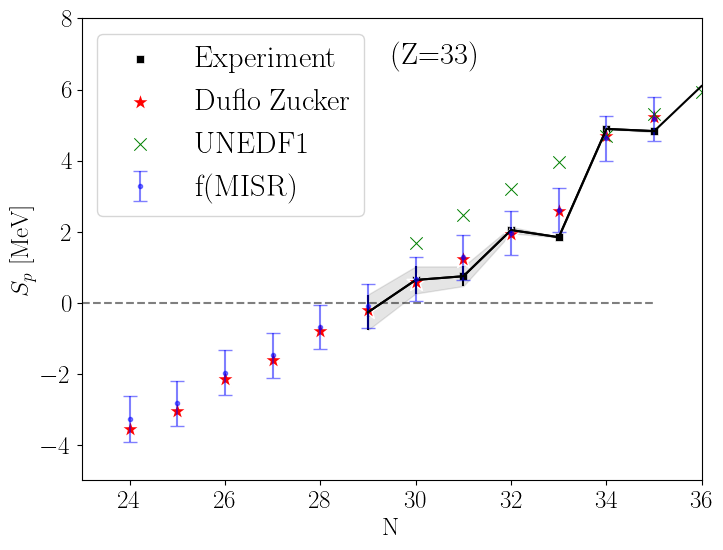

In [274]:
plot_sp_energy(33, 23, 35, "(Z=33)")

# Two neutron separation energies

In [70]:
def predict_s2n(Z, N, model):
    model_up = model(Z, N+2)
    model_down = model(Z, N)
    if isinstance(model_up, tuple):
        return model_up[0] - model_down[0], (model_up[1] + model_down[1])/2
    else:
        return model_up - model_down

def experimental_s2n(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "s2n_exp"] = df[(df["Z"] == row["Z"]) & (df["N"] == row["N"]+2)]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "s2n_exp"] = np.nan
    return df

def theory_s2n(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z) & (th_df["N"] == N+2)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan

def get_experimiental_unc_s2n(Z, N, df):
    try:
        return df[(df["Z"] == Z) & (df["N"] == N+2)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan

sep_df["exp_s2n"] = experimental_s2n(sep_df)["s2n_exp"]
sep_df["sr_s2n"] = sep_df.apply(lambda x: predict_s2n(x["Z"], x["N"], sr_be), axis=1)
sep_df["dz_s2n"] = sep_df.apply(lambda x: predict_s2n(x["Z"], x["N"], dz_be), axis=1)
ens_s2n = sep_df.progress_apply(lambda x: ensemble_sp(x["Z"], x["N"]), axis=1)
sep_df["ensemble_s2n"] = [x[0] for x in ens_s2n]
sep_df["unc_s2n"] = [x[1] for x in ens_s2n]

  0%|          | 0/1266 [00:00<?, ?it/s]

# Two proton separation energies

In [71]:
def predict_s2p(Z, N, model):
    model_up = model(Z+2, N)
    model_down = model(Z, N)
    if isinstance(model_up, tuple):
        return model_up[0] - model_down[0], (model_up[1] + model_down[1])/2
    else:
        return model_up - model_down

def experimental_s2p(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "s2p_exp"] = df[(df["Z"] == row["Z"]+2) & (df["N"] == row["N"])]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "s2p_exp"] = np.nan
    return df

def theory_s2p(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z+2) & (th_df["N"] == N)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan

def get_experimiental_unc_s2p(Z, N, df):
    try:
        return df[(df["Z"] == Z+2) & (df["N"] == N)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan

sep_df["exp_s2p"] = experimental_s2p(sep_df)["s2p_exp"]
sep_df["sr_s2p"] = sep_df.apply(lambda x: predict_s2p(x["Z"], x["N"], sr_be), axis=1)
sep_df["dz_s2p"] = sep_df.apply(lambda x: predict_s2p(x["Z"], x["N"], dz_be), axis=1)
ens_s2p = sep_df.progress_apply(lambda x: ensemble_sp(x["Z"], x["N"]), axis=1)
sep_df["ensemble_s2p"] = [x[0] for x in ens_s2p]
sep_df["unc_s2p"] = [x[1] for x in ens_s2p]


  0%|          | 0/1266 [00:00<?, ?it/s]

# Estimation of the probability of the separation energy being positive

In [72]:
import scipy.stats as stats
def probability_less_than_zero(mean, std_dev):
    """
    Estimate the probability of measuring a value smaller than 0
    for a normally distributed variable with given mean and standard deviation.

    Parameters:
    mean (float): The mean of the distribution.
    std_dev (float): The standard deviation (1-sigma) of the distribution.

    Returns:
    float: The probability of measuring a value less than 0.
    """
    # Use the CDF to find the probability that a value is less than 0
    probability = stats.norm.cdf(0, mean, std_dev)
    return probability


In [97]:
def estimate_proba_negative_sn(Z, N):
    # Get the mean and standard deviation of the ensemble of models
    # first look on sep_df to see if the values are there precomputed
    if Z in sep_df["Z"].values and N in sep_df["N"].values:
        mean = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["ensemble_sn"].values[0]
        std_dev = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["unc_sn"].values[0]
    else:
        mean, std_dev = ensembled_sn(Z, N)
    return probability_less_than_zero(mean, std_dev)

def estimate_proba_negative_sp(Z, N):
    # Get the mean and standard deviation of the ensemble of models
    mean, std_dev = ensemble_sp(Z, N)
    # first look on sep_df to see if the values are there precomputed
    if Z in sep_df["Z"].values and N in sep_df["N"].values:
        mean = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["ensemble_sp"].values[0]
        std_dev = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["unc_sp"].values[0]
    else:
        mean, std_dev = ensemble_sp(Z, N)
    return probability_less_than_zero(mean, std_dev)
def estimate_proba_negative_s2n(Z, N):
    # Get the mean and standard deviation of the ensemble of models
    if Z in sep_df["Z"].values and N in sep_df["N"].values:
        mean = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["ensemble_s2n"].values[0]
        std_dev = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["unc_s2n"].values[0]
    else:
        mean, std_dev = ensembled_sn(Z, N)
    return probability_less_than_zero(mean, std_dev)
def estimate_proba_negative_s2p(Z, N):
    # Get the mean and standard deviation of the ensemble of models
    if Z in sep_df["Z"].values and N in sep_df["N"].values:
        mean = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["ensemble_s2p"].values[0]
        std_dev = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["unc_s2p"].values[0]
    else:
        mean, std_dev = ensemble_sp(Z, N)
    return probability_less_than_zero(mean, std_dev)

In [98]:
def estimate_proba_bound(Z, N):
    # Estimate the probability of negative separation energies
    proba_negative_sn = estimate_proba_negative_sn(Z, N)
    proba_negative_sp = estimate_proba_negative_sp(Z, N)
    proba_negative_s2n = estimate_proba_negative_s2n(Z, N)
    proba_negative_s2p = estimate_proba_negative_s2p(Z, N)

    # Calculate the probability of positive separation energies
    proba_positive_sn = 1 - proba_negative_sn
    proba_positive_sp = 1 - proba_negative_sp
    proba_positive_s2n = 1 - proba_negative_s2n
    proba_positive_s2p = 1 - proba_negative_s2p

    # Calculate the total probability of the nucleus being bound
    # Assuming the separation energies are independent
    P_bound = proba_positive_sn * proba_positive_sp * proba_positive_s2n * proba_positive_s2p

    return P_bound


In [232]:
def find_experimental_driplines(df=sep_df):
    # Find the experimental dripline
    exp_sn = df["exp_sn"].values
    exp_sp = df["exp_sp"].values
    exp_s2n = df["exp_s2n"].values
    exp_s2p = df["exp_s2p"].values
    # Find the indices of the bound nuclei
    bound_indices = np.where((exp_sn > 0) & (exp_sp > 0) & (exp_s2n > 0) & (exp_s2p > 0))[0]
    # all the non bound nuclei are the dripline
    dripline_indices = np.where((exp_sn < 0) | (exp_sp < 0) | (exp_s2n < 0) | (exp_s2p < 0))[0]
    return bound_indices, dripline_indices

In [233]:
bound_indices, dripline_indices = find_experimental_driplines()

In [234]:
dripline_z_n = sep_df.query("Z>=12").query("Z<=50").iloc[dripline_indices][["Z", "N"]].values
dripline_z_n

array([[18, 25],
       [30, 28],
       [44, 43],
       [22, 28],
       [18, 14],
       [36, 34],
       [17, 13],
       [32, 28],
       [36, 35],
       [18, 18],
       [40, 39],
       [30, 44],
       [21, 15],
       [18, 36],
       [23, 17],
       [30, 25],
       [20, 15],
       [28, 20],
       [28, 42],
       [26, 20],
       [30, 26],
       [33, 29],
       [16, 32],
       [42, 42],
       [33, 30],
       [24, 18],
       [29, 24],
       [29, 25],
       [19, 16],
       [28, 25],
       [21, 17],
       [48, 48],
       [18, 34],
       [27, 23],
       [44, 44],
       [41, 40],
       [26, 22],
       [32, 27],
       [31, 28],
       [39, 38],
       [35, 31],
       [22, 16],
       [34, 31],
       [21, 16],
       [28, 24],
       [34, 34],
       [15, 11],
       [42, 41],
       [22, 17],
       [22, 19],
       [16, 12],
       [13,  9],
       [31, 29],
       [28, 26],
       [34, 30],
       [22, 18],
       [18, 13],
       [31, 27],
       [30, 27

In [235]:
estimate_proba_bound(17, 13)

0.5455245071473643

In [236]:
if True:
    # Define the ranges for Z and N
    Z_range = np.arange(14, 50)  # Proton number from 12 to 50 inclusive
    N_range = np.arange(10, 80)  # Neutron number up to 150 for demonstration

    # Initialize a matrix to hold the probabilities
    proba_matrix_sn = np.full((len(Z_range), len(N_range)), np.inf)
    proba_matrix_sp = np.full((len(Z_range), len(N_range)), np.inf)
    proba_matrix_s2n = np.full((len(Z_range), len(N_range)), np.inf)
    proba_matrix_s2p = np.full((len(Z_range), len(N_range)), np.inf)

    # Calculate the probabilities for the grid of (Z,N) values
    for i, Z in enumerate(tqdm(Z_range)):
        for j, N in enumerate(N_range):
            try:
                # neutron separation energy
                proba_matrix_sn[i, j] = estimate_proba_negative_sn(Z, N)
                proba_matrix_sp[i, j] = estimate_proba_negative_sp(Z, N)
                proba_matrix_s2n[i, j] = estimate_proba_negative_s2n(Z, N)
                proba_matrix_s2p[i, j] = estimate_proba_negative_s2p(Z, N)
            except Exception as e:
                print(e)
                proba_matrix_sn[i, j] = np.nan
                proba_matrix_sp[i, j] = np.nan
                proba_matrix_s2n[i, j] = np.nan
                proba_matrix_s2p[i, j] = np.nan


  0%|          | 0/36 [00:00<?, ?it/s]

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

In [237]:
all_bound_matrix = (1-proba_matrix_sn) * (1-proba_matrix_sp) * (1-proba_matrix_s2n) * (1-proba_matrix_s2p)

In [238]:
all_bound_matrix

array([[2.78076412e-13, 3.95918453e-04, 2.89950257e-02, ...,
                   nan,            nan,            nan],
       [1.78341354e-02, 3.75863129e-01, 9.96692401e-01, ...,
                   nan,            nan,            nan],
       [2.33942776e-40, 9.17365098e-19, 5.18699789e-14, ...,
                   nan,            nan,            nan],
       ...,
       [           nan,            nan,            nan, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [           nan,            nan,            nan, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [           nan,            nan,            nan, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [280]:
def plot_nuclear_chart(Z_range, N_range, proba_matrix = all_bound_matrix, title='Nuclear Stability Chart', ax=None,
                       sn_matrix=None, sp_matrix=None, s2n_matrix=None, s2p_matrix=None, dripline_z_n=dripline_z_n):
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 6))

    ax.set_facecolor('white')

    cmap = plt.cm.get_cmap('RdYlBu_r').reversed()

    chart = ax.imshow(proba_matrix, extent=(N_range[0], N_range[-1], Z_range[-1], Z_range[0]),
                      aspect='auto', cmap=cmap, alpha=0.75)

    # Draw a contour line where the probability is 0.5
    levels = [0.5]
    ct = ax.contour(N_range, Z_range, proba_matrix, levels, colors='k', linewidths=0.5)
    ax.clabel(ct, fmt='%2.1f', colors='black', fontsize=8)

    # remove the values in dripline_z_n list where the probability is very high from the drip line
    probs_in_dripline = np.array([[z,n] for z, n in dripline_z_n if estimate_proba_bound(z, n) < 0.8])

    ax.scatter(probs_in_dripline[:, 1], probs_in_dripline[:, 0], color='black', s=10, label='Confirmed\n Unbound Nuclei')
    ax.legend(fontsize=20)

    cbar = plt.colorbar(chart, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('$P_{bound}$', rotation=270, labelpad=15)
    ax.invert_yaxis()
    ax.set_xlabel('Neutron number N')
    ax.set_ylabel('Proton number Z')
    ax.set_title(title)
    ax.grid(True, color='black', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)

/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_11747/3416849711.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu_r').reversed()


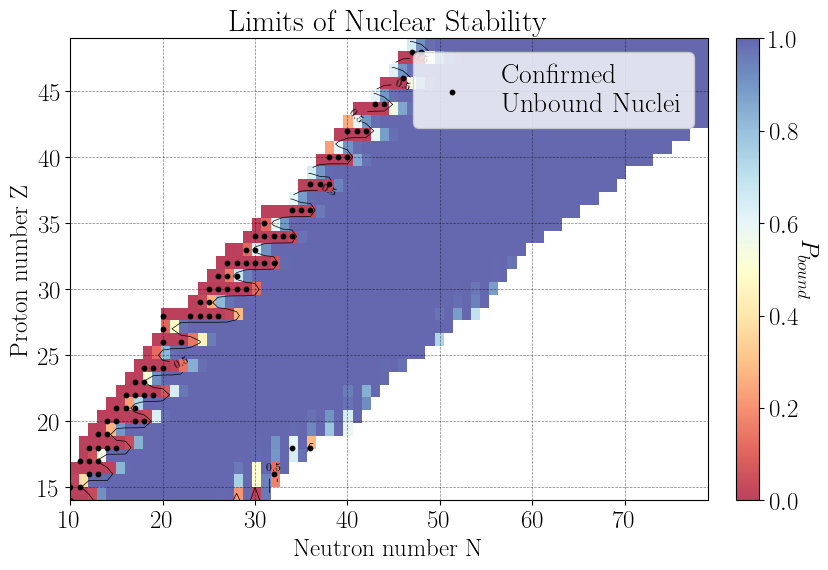

In [281]:


# Plot the probability matrix with the improved styling function
plot_nuclear_chart(Z_range, N_range, all_bound_matrix, 'Limits of Nuclear Stability', sn_matrix=proba_matrix_sn, sp_matrix=proba_matrix_sp, s2n_matrix=proba_matrix_s2n, s2p_matrix=proba_matrix_s2p)